In [1]:
import heapq
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

# Задача классификации текстов

Задача классификации текстов заключается в том, чтобы определить по документу его класс.
В данном случае предлагается рассмотреть в качестве документов - письма, заранее отклассифицированных по 20 темам.

In [2]:
all_categories = fetch_20newsgroups().target_names
all_categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Возьмём всего 3 темы, но из одного раздела (документы из близких тем сложнее отличать друг от друга)

In [3]:
categories = [
    'sci.electronics',
    'sci.space',
    'sci.med'
]

train_data = fetch_20newsgroups(subset='train',
                                categories=categories,
                                remove=('headers', 'footers', 'quotes'))

test_data = fetch_20newsgroups(subset='test',
                               categories=categories,
                               remove=('headers', 'footers', 'quotes'))

## Векторизация текстов
**Вопрос: как описать текстовые документы пространством признаков?**


**Идея №1**: мешок слов (bag-of-words) - каждый документ или текст выглядит как неупорядоченный набор слов без сведений о связях между ними.
<img src='https://st2.depositphotos.com/2454953/9959/i/450/depositphotos_99593622-stock-photo-holidays-travel-bag-word-cloud.jpg'>

**Идея №2**: создаём вектор "слов", каждая компонента отвечает отдельному слову.

Для векторизации текстов воспользуемся [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Можно всячески варировать извлечение признаков (убирать редкие слова, убирать частые слова, убирать слова общей лексики, брать биграмы и т.д.)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [6]:
count_vectorizer = CountVectorizer(min_df=5, ngram_range=(1, 2)) 

In [7]:
sparse_feature_matrix = count_vectorizer.fit_transform(train_data.data)
sparse_feature_matrix

<1778x10885 sparse matrix of type '<class 'numpy.int64'>'
	with 216486 stored elements in Compressed Sparse Row format>

In [8]:
num_2_words = {
    v: k
    for k, v in count_vectorizer.vocabulary_.items()
}

Слова с наибольшим положительным весом, являются характерными словами темы

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

Воспользуемся `macro`-average для оценки качества решения в задаче многоклассовой классификации.

In [10]:
f_scorer = make_scorer(f1_score, average='macro')

Обучим логистическую регрессию для предсказания темы документа

In [11]:
algo = LogisticRegression(C=0.00001)
%time algo.fit(sparse_feature_matrix, train_data.target)

CPU times: user 80.5 ms, sys: 6.62 ms, total: 87.1 ms
Wall time: 69.4 ms


/Users/dochkinavika/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/dochkinavika/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
W = algo.coef_.shape[1]
for c in algo.classes_:
    topic_words = [
        num_2_words[w_num]
        for w_num in heapq.nlargest(10, range(W), key=lambda w: algo.coef_[c, w])
    ]
    print(',  '.join(topic_words))


wire,  ground,  wiring,  circuit,  use,  neutral,  power,  current,  voltage,  cable
of,  health,  medical,  in,  edu,  my,  patients,  and,  disease,  she
space,  nasa,  launch,  earth,  orbit,  satellite,  shuttle,  lunar,  moon,  on


Сравним качество на обучающей и отложенной выборках.

In [13]:
%time algo.fit(sparse_feature_matrix, train_data.target)

CPU times: user 71.8 ms, sys: 2.13 ms, total: 73.9 ms
Wall time: 41.1 ms


LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
f_scorer(algo, sparse_feature_matrix, train_data.target)

0.42392759632757676

In [15]:
f_scorer(algo, count_vectorizer.transform(test_data.data), test_data.target)

0.38776774806066605

Значения f-меры получились очень низкие.
## <font color='red'> **Вопрос:** в чём причина низкоuо значения f-меры? </font>

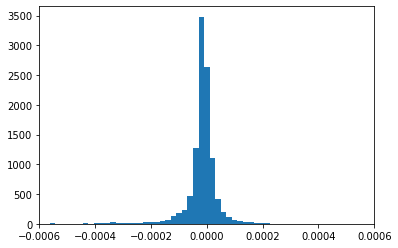

In [44]:
plt.hist(algo.coef_[0], bins=500)
plt.xlim([-0.0006, 0.0006])
plt.show()

** Какую выбрать метрику для регуляризации? **

In [45]:
algo = LogisticRegression(penalty='l1', C=0.1)
arr = cross_val_score(algo, sparse_feature_matrix, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/Users/dochkinavika/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/dochkinavika/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.72677114 0.74655622 0.7306948  0.74771699 0.71598339]
0.7335445102288912


## <font color='red'> **Вопрос:** обосновать выбор метрики  </font>

# 

In [46]:
algo.fit(sparse_feature_matrix, train_data.target)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
f_scorer(algo, sparse_feature_matrix, train_data.target)

0.7947271313945047

In [48]:
f_scorer(algo, count_vectorizer.transform(test_data.data), test_data.target)

0.6826822308876733

Подберём оптимальное значение параметра регуляризации

In [49]:
def grid_plot(x, y, x_label, title, y_label='f_measure'):
    plt.figure(figsize=(12, 6))
    plt.grid(True),
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [50]:
print(*map(float, np.logspace(-2, 2, 10)))

0.01 0.027825594022071243 0.0774263682681127 0.21544346900318834 0.5994842503189409 1.6681005372000592 4.6415888336127775 12.915496650148826 35.93813663804626 100.0


In [51]:
lr_grid = {
    'C': np.logspace(-2, 2, 10),
}
gs = GridSearchCV(LogisticRegression(penalty='l1'), lr_grid, scoring=f_scorer, cv=5, n_jobs=5)
%time  gs.fit(sparse_feature_matrix, train_data.target)
print("best_params: {}, best_score: {}".format(gs.best_params_, gs.best_score_))

/Users/dochkinavika/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/dochkinavika/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 16.5 s, sys: 34.3 ms, total: 16.5 s
Wall time: 2min 9s
best_params: {'C': 12.915496650148826}, best_score: 0.809716759320542


/Users/dochkinavika/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Рассмотрим график:

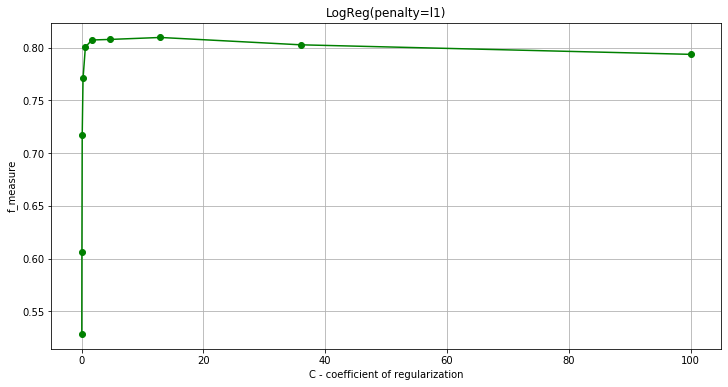

In [52]:
grid_plot(
    lr_grid['C'], gs.cv_results_['mean_test_score'], 'C - coefficient of regularization', 'LogReg(penalty=l1)'
)

In [53]:
lr_grid = {
    'C': np.linspace(1, 20, 40),
}
gs = GridSearchCV(LogisticRegression(penalty='l1'), lr_grid, scoring=f_scorer, cv=5, n_jobs=5)
%time  gs.fit(sparse_feature_matrix, train_data.target)
print("best_params: {}, best_score: {}".format(gs.best_params_, gs.best_score_))

KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
grid_plot(
    lr_grid['C'], gs.cv_results_['mean_test_score'], 'C - coefficient of regularization', 'LogReg(penalty=l1)'
)

In [ ]:
lr_final = LogisticRegression(penalty='l1', C=10)
%time lr_final.fit(sparse_feature_matrix, train_data.target)

In [ ]:
accuracy_score(lr_final.predict(sparse_feature_matrix), train_data.target)

In [ ]:
f_scorer(lr_final, sparse_feature_matrix, train_data.target)

In [ ]:
accuracy_score(lr_final.predict(count_vectorizer.transform(test_data.data)), test_data.target)

In [ ]:
f_scorer(lr_final, count_vectorizer.transform(test_data.data), test_data.target)

## Регуляризация вместе с векторизацией признаков
Чтобы не делать векторизацию и обучение раздельно, есть удобный класс Pipeline. Он позволяет объединить в цепочку последовательность действий

In [36]:
from sklearn.pipeline import Pipeline

In [81]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(min_df=5, ngram_range=(1, 2))),
    ("algo", LogisticRegression())
])

In [82]:
pipeline.fit(train_data.data, train_data.target)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [83]:
f_scorer(pipeline, train_data.data, train_data.target)

0.9804363797868283

In [84]:
f_scorer(pipeline, test_data.data, test_data.target)

0.7930204194507636

## <font color='red'> **Вопрос:** обосновать улучшение результата</font>

Значения такие же как мы получали ранее, делая шаги раздельно.

In [17]:
from sklearn.pipeline import make_pipeline

При кроссвалидации нужно, чтобы CountVectorizer не обучался на тесте (иначе объекты становятся зависимыми). Pipeline позволяет это просто сделать.

In [79]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.83746513 0.84655975 0.82308768 0.83985549 0.83173934]
0.8357414775322148


В Pipeline можно добавлять новые шаги препроцессинга данных

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

In [86]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), TfidfTransformer(), LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.8711115  0.8703129  0.8482986  0.85701424 0.84020672]
0.8573887943863149


In [87]:
pipeline.fit(train_data.data, train_data.target)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
  ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [90]:
accuracy_score(pipeline.predict(train_data.data), train_data.target)

0.96962879640045

In [91]:
f_scorer(pipeline, train_data.data, train_data.target)

0.9697797455997105

In [92]:
accuracy_score(pipeline.predict(test_data.data), test_data.target)

0.8241758241758241

In [93]:
f_scorer(pipeline, test_data.data, test_data.target)

0.8250417787917681

Качество стало немного лучше

## <font color='red'> **Вопрос:** обосновать улучшение результата </font>

# Классификация сообщений чатов

В качестве задания предлагается построить модель классификации текстов, соответствующих сообщениям из чатов по ML, Python и знакомствам.

**Данные** можно взять с <a src="https://www.kaggle.com/c/tfstextclassification">соревнования на Kaggle</a>, проведенное в рамках курса "Диалоговые системы" в Тинькофф. Прямая [ссылка](https://www.dropbox.com/s/8wckwzfy63ajxpm/tfstextclassification.zip?dl=0) на скачивание.

In [20]:
data_path = 'data/{}'
df = pd.read_csv('train.csv')

### Первичный анализ данных

In [21]:
print(df.shape)

(112467, 3)


In [22]:
df.head()

,id,text,label
0,0,ж 44 позн с мужч от 40 лет 0678935919,1
1,1,уже и не вспомню где это увидел,2
2,2,", sep=';', decimal=',' может изза этого",2
3,3,НУЖНА ДЕВ ДЛЯ С\\О -19л.0637048428смс,1
4,4,.М54.ИЩУ Д.Ж. С-П.ДЛЯ ЛАСК...НЕКМ.0508665030....,1


In [23]:
label = 0
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  0 

Тогда какое это отношение имеет к обсуждению лонгполлинга?
----------------------------------------------------------------------------------------------------

И NFS -- далеко не в каждом смартфоне.
----------------------------------------------------------------------------------------------------

Либо pip3 import, либо pip import...
----------------------------------------------------------------------------------------------------

точнее как, у меня список массивов, надо слепить их вместе в один масси
----------------------------------------------------------------------------------------------------

gateway вроде работает,только теперь нужна нейронка чтобы убрать прон
----------------------------------------------------------------------------------------------------

это что вообще и зачем? объясни человечьим языком, какую задачу ты этим пытаешься решить?
----------------------------------------------------------------------------------------------------

Не крутит

In [24]:
label = 1
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  1 

Мужч.ищ.дев./ж для приятн.встреч из Днепродз.096 098 58 11
----------------------------------------------------------------------------------------------------

м48 соска днепр.сечас.0661646131
----------------------------------------------------------------------------------------------------

крас п на авто взаимные ласки 0954115362
----------------------------------------------------------------------------------------------------

Кумовья харе сидеть возле телика! Идите приятное  делать! От кумы
----------------------------------------------------------------------------------------------------

Есть женщины35-45лет которым интересен эр-ий массаж с женщинои?0638508804смс
----------------------------------------------------------------------------------------------------

М.36 позн.с одинокой скромной женщ без вр.прив.С/О.  067-970- 880
----------------------------------------------------------------------------------------------------

звоните мне родные) жду вас =*
---

In [25]:
label = 2
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  2 

если ты получишь предиктед 322, при актуал 1\nэто модель плохая, тут тебе ничего не поможет
----------------------------------------------------------------------------------------------------

по сути вроде у одного абонента с 12 измерений не сильно что-то поменялось
----------------------------------------------------------------------------------------------------

Alexey ты был на IDAO в том году?
----------------------------------------------------------------------------------------------------

как любая массовая вещь - кэгл становится более попсовым но от этого не хуже
----------------------------------------------------------------------------------------------------

Как будто если бы обсуждения переехали в другой чатик, никак не связанный с млбуткемпом, то что-то бы поменялось принципиально.
----------------------------------------------------------------------------------------------------

Разные виды сеток имеются в виду?
--------------------------------------

### Разделим данные на train/test

In [26]:
skf = StratifiedKFold(3, random_state=37)
train_index, test_index = next(skf.split(df.text, df.label))
train_df, test_df = df.iloc[train_index], df.iloc[test_index]
print(train_df.shape, test_df.shape)

(74977, 3) (37490, 3)


In [27]:
train_df.head()

,id,text,label
37334,37334,.Молодой красивый спортивный парень ищет серьё...,1
37335,37335,вы озабоченые уточняю для даши было написано:)...,1
37336,37336,КАБАСЯ Я ТЕБЯ ЛЮБЛЮ И ОЧЕНЬ СКУЧАЮ...ТВОЯ ВИТА...,1
37337,37337,парень ищет парня для и\\о 093 783 37 87,1
37339,37339,РОЗСЛАБЛЮ В НОЧНОЕ ВРЕМЯ ПО ТЕЛЕФОНУ.ЦЕНА 10Г....,1


In [28]:
test_df.head()

,id,text,label
0,0,ж 44 позн с мужч от 40 лет 0678935919,1
1,1,уже и не вспомню где это увидел,2
2,2,", sep=';', decimal=',' может изза этого",2
3,3,НУЖНА ДЕВ ДЛЯ С\\О -19л.0637048428смс,1
4,4,.М54.ИЩУ Д.Ж. С-П.ДЛЯ ЛАСК...НЕКМ.0508665030....,1


## Baseline

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from xgboost.sklearn import XGBClassifier

Преобразуем данные

In [33]:
X_train = train_df.text
y_train = train_df.label
print(X_train.shape)

X_test = test_df.text
y_test = test_df.label
print(X_test.shape)

(74977,)
(37490,)


In [34]:
X_train

37334     .Молодой красивый спортивный парень ищет серьё...
37335     вы озабоченые уточняю для даши было написано:)...
37336     КАБАСЯ Я ТЕБЯ ЛЮБЛЮ И ОЧЕНЬ СКУЧАЮ...ТВОЯ ВИТА...
37337             парень ищет парня  для и\\о 093 783 37 87
37339     РОЗСЛАБЛЮ В НОЧНОЕ ВРЕМЯ ПО ТЕЛЕФОНУ.ЦЕНА 10Г....
                                ...                        
112462    . Мужч. 45. Общение с женщиной. ВНАЧАЛЕ СМС  М...
112463                       чем не устраивает канал в ODS?
112464    ДОЦЯ ОЧЕНЬ РЕСКА ПАВАРАЧЕВАТЬ НЕЛЬЗЯ. БУДЬ ЧЮТ...
112465    Привет наш любимый дорогой сыночек.Очень скуча...
112466    ? сегодня услышал kmean от гуманитария на рабо...
Name: text, Length: 74977, dtype: object

## <font color='red'> Задание: применить TF-IDF для кодирования текстовой информациии и затем обучить модель</font>
будьте внимательны, что к валидационной части данных также необходимо применить эту процедуру

Также можно использовать другие методы кодированния текстов и затем сравнить полученные результаты

Подготовим pipeline

In [37]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("clf", DecisionTreeClassifier()),
])

###  <font color='red'> Задание: Протестировать различные параметры CountVectorizer()</font>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


Обучим классификатор

In [38]:
%%time
clf = pipeline
clf.fit(X_train, y_train)

CPU times: user 40.7 s, sys: 138 ms, total: 40.8 s
Wall time: 40.8 s


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                         

Оценим качество

In [39]:
print("Train_acc: {:.4f}, train_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_train), y_train),
    f_scorer(clf, X_train, y_train)
))

Train_acc: 0.9998, train_f-measure: 0.9998


In [40]:
print("Test_acc: {:.4f}, test_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_test), y_test),
    f_scorer(clf, X_test, y_test)
))

Test_acc: 0.7884, test_f-measure: 0.7236


## <font color='red'> Задание: улучшить результат и сделать вывод о влиянии использованных методов на итоговый результат

### Your turn

Как видим, наша модель переобучилась. Для получения лучших результатов попробуйте воспользоваться более хитрыми и походящими инструментами.

1. Попробуйте поработать с параметрами `CountVectorizer`.
2. Попробуйте воспользоваться TF-IDF для кодирования текстовой информации ([ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).
3. Попробуйте воспользоваться другими моделями и средствами снижения размерности.

Формальный критерий успешности выполнения данного задания: 
* Проведен честный эксперимент с апробацией различных методов (>=3)
* Полученный алгоритм не выказывает явных следов переобучения (качество на train и test не различаются более, чем на 0.03 условных попугая)
* Test accuracy >= 0.835, f1-score >= 0.815

**0.5 extra points**

При частичном выполнении данного задания можно получить неполный балл. Качественный эксперимент, не побивший пороговые значения оценивается неполным баллом на усмотрение преподавателя. При получении пороговых score'ов случайным образом (без анализа) бонус не засчитывается. 